# Methods for counting bitflip positions in Pyshark captures

* Problem: Got a large capture file (pcap) with $P$ equal-sized packets of $N$ bits UDP payload. Every set bit (non-zero bit) indicates a bitflip. We want to know the statistics of these bitflips, with respect to their position $i$ among the packet. This is a computationally intensive task.
* Approach: Load the capture into Pyshark. Walk over the packets and extract the UDP payload. For every caught bitflip, increment an array at the corresponding position $i$. When finished, the array holds the number of bitflips at positions $i=0\ldots N-1$. Compare different methods to achieve this and do benchmarks for them.

In [1]:
import mypyshark as pyshark # modified version to support tcpdump -C (wireshark profile selection..)
import numpy as np

In [2]:
def load_capture(filename, flt=''):
    print("[Pyshark] Opening {} with display_filter='{}' ".format(filename,flt))
    return pyshark.FileCapture(
        filename, 
        display_filter=flt, 
        configuration_profile='udp_only' # needs Pyshark hack (mypyshark package)!
    )

### Notes (occurred while working): 
* Payload can be retrieved as
    * integer of bitness $N$, not very useful
    * `bytes`-Object, basically a string without character encoding. Can be unpacked to single integer bytes using `list()`. Update: Or with `memoryview()`!
    * hex-coded data as string (useless)

* [2018-03-15] pyshark/tshark: protocol decoders above transport layer are annoying, as they false-detect protocols due to bit errors and try to decode them, and do not provide raw data. Leads to unset pkt.data and AttributeError
    * Disabling protocols not possible with pyshark and not even with Tshark! Need to start wireshark, disable all protocols except Ethernet, 802.11, IPv4 and UDP and save it as "configuration profile". Tshark can use that with the -C option at least, but Pyshark has no mapping to that. 
    * Only option: Hack pyshark files! Added possibility to specify wireshark configuration profile with kwarg "configuration_profile" in FileCapture/Capture. Saved as new module `mypyshark` in working directory. Possibly contribute that..
    * Now all packets are given with raw UDP payload!


In [3]:
def bitflip_poscount(cap, pktlimit=-1, method='pythoniterate'):
    # pktlimit -1 is no limit
    poscounts = np.zeros(1000*8, dtype='uint32') # todo make this responsive
    if method == 'pythoniterate':
        for pkt in cap:
            if pktlimit == 0: break
            pktlimit -= 1
            # iterate byte-wise over data field and then bit-wise over byte
            poscounts += [
                np.uint32(pbytedata >> pbitpos & 1) # get bit at position pbitpos
                #print("byte at pos {}, bit {}: {}".format(pbytepos, pbitpos, (pbytedata >> pbitpos) & 1))
                for pbytepos,pbytedata in enumerate(list(pkt.data.data.binary_value)) # walk all the bytes
                for pbitpos in range(0,8) # walk bits in byte
            ]
    if method == 'pythoniterate_mv':
        for pkt in cap:
            if pktlimit == 0: break
            pktlimit -= 1
            # iterate byte-wise over data field and then bit-wise over byte
            poscounts += [
                np.uint32(pbytedata >> pbitpos & 1) # get bit at position pbitpos
                #print("byte at pos {}, bit {}: {}".format(pbytepos, pbitpos, (pbytedata >> pbitpos) & 1))
                for pbytepos,pbytedata in enumerate(memoryview(pkt.data.data.binary_value)) # walk all the bytes
                for pbitpos in range(0,8) # walk bits in byte
            ]
    elif method == 'unpackbits':
        for pkt in cap:
            if pktlimit == 0: break
            pktlimit -= 1
            # make numpy array from whole data field and use np.unpackbits
            poscounts += np.unpackbits(
                    np.array(
                        list(pkt.data.data.binary_value), # unpack bytes object to single integer bytes
                    np.uint8), # force uint8 for the array (moree is not needed)
                )
    elif method == 'unpackbits_mv':
        for pkt in cap:
            if pktlimit == 0: break
            pktlimit -= 1
            # make numpy array from whole data field and use np.unpackbits
            poscounts += np.unpackbits(
                    np.array(
                        memoryview(pkt.data.data.binary_value), # makes bytes iterable
                    np.uint8), # force uint8 for the array (moree is not needed)
                )
    return poscounts

In [4]:
%%timeit -n1 -r5 cap = load_capture('../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap')
flips_purepython = bitflip_poscount(cap, pktlimit=1000, method='pythoniterate')
del cap, flips_purepython

[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap with display_filter='' 
[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap with display_filter='' 
[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap with display_filter='' 
[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap with display_filter='' 
[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap with display_filter='' 
1 loop, best of 5: 5.28 s per loop


In [4]:
%%timeit -n1 -r5 cap = load_capture('../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap')
flips_purepython_mv = bitflip_poscount(cap, pktlimit=1000, method='pythoniterate_mv')

[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap with display_filter='' 
[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap with display_filter='' 
[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap with display_filter='' 
[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap with display_filter='' 
[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap with display_filter='' 
1 loop, best of 5: 4.93 s per loop


In [5]:
%%timeit -n1 -r5 cap = load_capture('../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap')
flips_unpackbits = bitflip_poscount(cap, pktlimit=1000, method='unpackbits')

[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap with display_filter='' 
[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap with display_filter='' 
[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap with display_filter='' 
[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap with display_filter='' 
[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap with display_filter='' 
1 loop, best of 5: 1.15 s per loop


In [4]:
%%timeit -n1 -r5 cap = load_capture('../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap')
flips_unpackbits_mv = bitflip_poscount(cap, pktlimit=1000, method='unpackbits_mv')

[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap with display_filter='' 
[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap with display_filter='' 
[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap with display_filter='' 
[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap with display_filter='' 
[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap with display_filter='' 
1 loop, best of 5: 1.11 s per loop


### Results

Unpackbits is faster by factor 4-5.

Using `memoryview` instead of `list` on the bytes object bringts further improvement

### How the test captures are generated
Input is an artificially generated capture (via localhost) that flips bits with probability $p$. Additionally, a parameter $s$ (slope) was added, which allows to change $p$ linearly over time. More precise, in a packet with $N$ bits, the bit at position $i$ is flipped with probability
$$
p'(i) = p+ s \left( \frac{1}{2} - \cdot\frac{i}{N} \right)
$$
where $p$ still denotes the mean flip probability.

This has been implemented as a Python script and recorded via Tshark into a pcap file.

### Example

In the below example, a capture with $p=0.2$ and $s=-1.0$ (more flips at the end) is loaded. Packets are of size 1kB (8000 bits) and the total number of packets is $2^{16} = 16384$.

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

cap = load_capture('../captures/udp_1kb_wfakeerrors_p0.2_s-1.0.pcap')
flipcounts = bitflip_poscount(cap, method='unpackbits_mv') # no packet limit this time

[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s-1.0.pcap with display_filter='' 


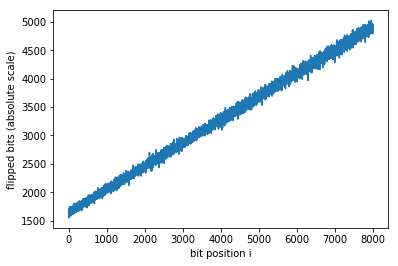

recorded 131072000 bits, total flipped bits: 26214316 (20.00%)


In [6]:
plt.plot(flipcounts)
plt.xlabel('bit position i'); plt.ylabel('flipped bits (absolute scale)');
plt.show()
print("recorded {} bits, total flipped bits: {} ({:.2%})".format(16384*8000, flipcounts.sum(), flipcounts.sum()/(16384*8000)))